In [1]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
import sentence_transformers
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig
from transformers import AutoTokenizer, AutoModel

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from DeBERTa import deberta
from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
model_name = 'roberta-large'

In [4]:
def config_model():
    configuration = AutoConfig.from_pretrained(model_name)

    configuration.hidden_dropout_prob = 0.0
    configuration.attention_probs_dropout_prob = 0.0
    configuration.classifier_dropout = 0.0
    
    return configuration

config = config_model()
size = config.hidden_size

In [5]:
# ROBERTa model

# tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)
# embeddings_model = RobertaModel.from_pretrained(model_name, config=config_model())


## Data

In [6]:
summaries_train_path = r"dataset\summaries_train_merged.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [7]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')
    
    return df

def short_text(text, max_length=200) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]
        
        text = short_text(text_pt1) + short_text(text_pt2)

    summarizer = pipeline("summarization", model="bart-large-cnn")

    # summarizer.model.to(device)

    summarized = summarizer(text, max_length=max_length, min_length=80, do_sample=False)
    
    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """
    
    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))
        
    return average_array


def mean_pooling(outputs, batch) -> torch.tensor:
    
    attention_mask = batch['attention_mask']
    embeddings = outputs.last_hidden_state
    
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
    mean_pooled = summed/summed_mask
    
    return mean_pooled

def normilize(df_column: pd.DataFrame):
    
    df_column = (df_column - df_column.mean())/df_column.std()
    
    return df_column

def get_cos_sim(df):
    sentence_1 = df.text
    sentence_2 = df.prompt_text

    sentence_tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
    sentence_model = AutoModel.from_pretrained('all-mpnet-base-v2')

    cos_sim_list = []
    sentence_model.to(device)

    for i, summarie in enumerate(tqdm(sentence_1)):
        prompt = sentence_2[i]
        inputs = sentence_tokenizer([summarie, prompt], padding=True,
                                    return_tensors='pt', truncation=True)
        inputs.to(device)

        with torch.no_grad():
            outputs = sentence_model(**inputs)

        sentence_embeddings = mean_pooling(outputs, inputs)
        sentence_embeddings = F.normalize(sentence_embeddings)

        score = nn.CosineSimilarity(dim=0)(sentence_embeddings[0], sentence_embeddings[1])

        cos_sim_list.append(score.item())

    return cos_sim_list

def get_stat_features(df, text_col="text"):
    
    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))
    
    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",") 
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    # df['cos_sim'] = normilize(pd.DataFrame(get_cos_sim(df)))
    
    return df

In [8]:
# with open(prompts_train_path, encoding='utf-8') as f:
#     prompts = pd.read_csv(f)
#     for i, text in enumerate(prompts.prompt_text):
#             if len(text.split()) > 300:
#                 prompts.prompt_text[i] = short_text(text)
#
# with open(summaries_train_path, encoding='utf-8') as f:
#     summaries = pd.read_csv(f)
#     summaries = summaries.merge(prompts, how="left", on="prompt_id")
#     summaries = get_stat_features(summaries)

In [9]:
class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='wording', test=False, fold_test='ebad26'):
        self.test = test
        self.score_type = score
        self.fold_test = fold_test

        with open(prompts_path, encoding='utf-8') as f:
            self.prompts = pd.read_csv(f)

        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            self.summaries = summaries
        
    def __len__(self):
        return len(self.__summaries)
    
    @property
    def summaries(self):
        return self.__summaries
    
    @summaries.setter
    def summaries(self, df):
        if self.test:
            self.__summaries = df[df.prompt_id == self.fold_test].reset_index(drop=True)
            
        else:
            self.__summaries = df[df.prompt_id != self.fold_test].reset_index(drop=True)
    
    @property
    def prompts(self):
        return self.__prompts
    
    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
        # for i, text in enumerate(self.__prompts.prompt_text):
        #     if len(text.split()) > 300:
        #         self.__prompts.prompt_text[i] = short_text(text)
    
    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]

        if True:
            res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
            res = {k:val.squeeze() for k, val in res.items()}
            res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)
            
            return res
            
        prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
                                               self.summaries.prompt_id[index]].item().replace('\n','')
        
        return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)
    
    def get_score(self, index):
        if self.score_type == 'content':
            score = self.summaries.content[index]

        elif self.score_type == 'wording':
            score = self.summaries.wording[index]

        return torch.tensor(score)

    # def get_score(self, index):
    #
    #     score = [self.summaries.content[index], self.summaries.wording[index]]
    #
    #     return torch.tensor(score)
        
    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)
        
        return batch_text, batch_score

In [10]:
# dataset = SentenseData()

In [11]:
# train_data = DataLoader(dataset, batch_size=5, shuffle=True)

In [12]:
# for batch in train_data:
#     shme=batch
#     break

In [13]:
# x, y = shme

In [14]:
# model = STSBertModel()

In [15]:
# y_hat = model(x)

In [16]:
# y_hat.shape

In [17]:
# loss = MCRMSELoss()

In [18]:
# y.unsqueeze(1)

In [19]:
# loss(y_hat.squeeze(), y)

In [20]:
# from scipy.stats import pearsonr
#
# pearsonr(dataset.summaries.num_unique_words, dataset.summaries.content)

## Model

In [21]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=True, input_size=size):
        super(STSBertModel, self).__init__()
        
        self.word_embedding = RobertaModel.from_pretrained(model_name, config=config)
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 5
            self.input_size += self.n_features

        # for param in self.word_embedding.parameters():
        #     param.requires_grad = False

        self.attention = SelfAttention(self.input_size)
        self.block = AttentionBlock(self.input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, self.input_size)),
            ('relu1', nn.ReLU()),
            # ('fc2', nn.Linear(1024, self.input_size)),
            # ('relu2', nn.ReLU())
            ]))

        self.FC_output = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1)),
            ]))
    
    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)

        if self.with_features:
            output = torch.cat((output, x['features']), dim=1)

        output = output.unsqueeze(1)
        output = self.attention(output)
        output = self.FC_output(output)

        return output


class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()

        self.input_dim = input_dim
        self.fc = nn.Linear(input_dim, input_dim)
        self.attention = SelfAttention(input_dim)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        identity = x

        x = self.attention(x)
        x = self.fc(x)

        x += identity
        x = self.norm(x)
        x = self.relu(x)

        return x


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


In [22]:
# class ClassificationModel(nn.Module):
#     def __init__(self, n_features, n_fold):
#         super(ClassificationModel, self).__init__()
#
#         self.n_fold = n_fold
#         self.n_features = n_features
#         self.fc_input = nn.Linear(n_features, 512)
#         self.fc_1 = nn.Linear(512, 512)
#         self.fc_2 = nn.Linear(512, 256)
#         self.fc_output = nn.Linear(256, 1)
#         self.relu = nn.ReLU()
#         self.score_model = STSBertModel()
#
#         for param in self.score_model.parameters():
#             param.requires_grad = False
#
#     @property
#     def score_model(self):
#         return self.__score_model
#
#     @score_model.setter
#     def score_model(self, model_init):
#         model = model_init
#
#         model.load_state_dict(torch.load(r'models\cv_2\best__fold_{}.pt'.format(self.n_fold)))
#
#         return model
#
#     def forward(self, x):
#         features = x['features']
#
#         x = self.score_model(x)
#
#         x = torch.cat((x.squeeze(1), features), dim=1)
#
#         x = self.fc_input(x)
#         x = self.relu(x)
#
#         x = self.fc_1(x)
#         x = self.relu(x)
#
#         x = self.fc_1(x)
#         x = self.relu(x)
#         x = self.fc_1(x)
#         x = self.relu(x)
#
#         x = self.fc_2(x)
#         x = self.relu(x)
#
#         x = self.fc_output(x)
#
#         return x

In [23]:
# class STSBertModel(nn.Module):
#     """
#     Sentence Semantic Similarity Bert model
#     :param: seg_head=True for using segmentation head instead of cosine similarity
#     :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
#     """
#     def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
#         super(STSBertModel, self).__init__()
        
#         self.word_embedding = RobertaModel.from_pretrained('roberta-base', config=config_model())
#         self.cos_sim = nn.CosineSimilarity(dim=0)
#         self.identity = nn.Identity()
#         self.seg_head = seg_head
#         self.fc = nn.Sequential(OrderedDict([
#             ('fc1', nn.Linear(input_size*2, 1024)),
#             ('tanh', nn.Tanh()),
#             ('fc2', nn.Linear(1024, 256)),
#             ('tanh', nn.Tanh()),
#             ('output', nn.Linear(256, 1)),
#         ]))
        
        
#         if seg_head:
# #             self.FC_head = SbertHead(inputs=768)
#             self.FC_head = nn.Sequential(OrderedDict([
# #                 ('dropout1', nn.Dropout(0.2)),
#                 ('fc_input', nn.Linear(input_size, 1024)),
#                 ('relu1', nn.ReLU()),
#                 ('fc1', nn.Linear(1024,1024)),
# #                 ('dropout2', nn.Dropout(0.2)),
# #                 ('batch_norm1', nn.BatchNorm1d(1024)),
#                 ('relu2', nn.ReLU()),
#                 ('fc2', nn.Linear(1024, 512)),
#                 ('relu3', nn.ReLU()),
# #                 ('dropout2', nn.Dropout(0.2)),
#                 ('fc3', nn.Linear(512, 512)),
# #                 ('batch_norm2', nn.BatchNorm1d(512)),
#                 ('relu4', nn.ReLU()),
#                 ('fc4', nn.Linear(512, 256)),
# #                 ('batch_norm3', nn.BatchNorm1d(256)),
#                 ('relu5', nn.ReLU()),
# #                 ('dropout3', nn.Dropout(0.2)),
#                 ('fc5', nn.Linear(256, 64)),
#                 ('relu6', nn.ReLU()),
#                 ('fc_output', nn.Linear(64, 1))
# #                 ('activation', nn.Sigmoid())
#             ]))
            
#         if freeze_weights:
#             self.freeze()
    
#     def freeze(self):
#         for param in self.word_embedding.parameters():
#             param.requires_grad = False
    
#     @staticmethod
#     def mean_pooling(outputs, batch) -> torch.tensor:
        
#         attention_mask = batch['attention_mask']
#         embeddings = outputs.last_hidden_state
    
#         mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
#         masked_embeddings = embeddings * mask
    
#         summed = torch.sum(masked_embeddings, 1)
#         summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
#         mean_pooled = summed/summed_mask
    
#         return mean_pooled
    
#     def cos_score(self, x):
#         embedding_1 = x[0]
#         embedding_2 = x[1]
#         emb = torch.concat((embedding_1, embedding_2))
        
        
        
#         cos_score = self.fc(emb)
        
# #         cos_score = self.cos_sim(embedding_1, embedding_2)
# #         cos_score = torch.sigmoid(cos_score)
        
#         return cos_score
    
#     def forward(self, x):
#         output = self.word_embedding(**x)
#         output = self.mean_pooling(output, x)
# #         output = output[1]
        
#         if self.seg_head:
#             output = self.FC_head(output)
        
#         else:
#             output = self.cos_score(output)
        
#         return output

In [24]:
# score_type = 'wording'
# batch_size = 15

# test_data = SentenseData(test=True, score=score_type)
# train_data = SentenseData(score=score_type)

# train_loader = DataLoader(train_data,
#                            batch_size=batch_size,
#                            shuffle=True)

# test_loader = DataLoader(test_data,
#                           batch_size=batch_size,
#                           shuffle=True)

## Training

In [25]:
# model = STSBertModel(seg_head=True, freeze_weights=False)

# model.float()

# model.to(device)

In [26]:
# Loss_func = nn.MSELoss()

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-06, weight_decay=2e-04)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

# scaler = torch.cuda.amp.GradScaler()

In [27]:
class MCRMSELoss(nn.Module):
    def __init__(self, num_scores=2):
        super().__init__()
        self.MSELoss = nn.MSELoss()
        self.num_scores = num_scores

    def forward(self, y_hat, y):
        score = 0
        for i in range(self.num_scores):
            score += torch.sqrt(self.MSELoss(y_hat[:,i], y[:,i]))

        return score / self.num_scores

In [28]:
train_dev_split = True

In [29]:
def validate_model(model, loss_func):

    losses_epoch_test = []
    losses_epoch_train_dev = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float().to(device)

            inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)

            loss = torch.sqrt(loss_func(outputs.squeeze(), targets))

            losses_epoch_test.append(loss.item())

        if train_dev_split:

            for inputs, targets in train_dev_loader:
                targets = targets.float().to(device)

                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)

                loss = torch.sqrt(loss_func(outputs.squeeze(), targets))

                losses_epoch_train_dev.append(loss.item())

    return losses_epoch_test, losses_epoch_train_dev


def train_model(n_epochs, lr, weight_decay, n_fold, lr_head):
    
    model = STSBertModel(with_features=True)
    # model = ClassificationModel(n_features=7, n_fold=n_fold)

    model.float()
    model.to(device)

    params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': lr_head},
        {'params': model.block.parameters(), 'lr': lr_head},
        {'params': model.FC_head.parameters(), 'lr': lr_head},
        {'params': model.FC_output.parameters(), 'lr': lr_head}
    ]
    
    loss_func = nn.MSELoss()
    # loss_func = MCRMSELoss()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.8, verbose=True)
    # warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1e-8, 1, 150, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9992, verbose=False)
    scaler = torch.cuda.amp.GradScaler()
    
    losses_train = []
    losses_test = []
    losses_train_dev = []

    t0 = datetime.now()

    for i in range(n_epochs):
    
        losses_train_per_epoch = []
    
        for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
            inputs, targets = batch
            targets = targets.float().to(device)
        
            model.train()
        
            optimizer.zero_grad()
        
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)
            
                loss = torch.sqrt(loss_func(outputs.squeeze(), targets))
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
        
            scaler.update()

            lr_scheduler.step()
            # warmup_scheduler.step()
            losses_train_per_epoch.append(loss.item())
        
            if j%20 == 0 or j == len(train_loader):
            
                losses_test_per_epoch, losses_test_dev_epoch = validate_model(model, loss_func)
                losses_test_mean = np.mean(losses_test_per_epoch)
                losses_train_mean = np.mean(losses_train_per_epoch)
                if train_dev_split:
                    losses_train_dev_mean = np.mean(losses_test_dev_epoch)

                losses_train.append(losses_train_mean)
                losses_test.append(losses_test_mean)
                if train_dev_split:
                    losses_train_dev.append(losses_train_dev_mean)

                if losses_test_mean == np.min(losses_test):
                    best_score = losses_test_mean
                    n_iter = len(losses_train)
                    torch.save(model.state_dict(), r'models\cv\best__fold_{}.pt'.format(n_fold))
                    print(f'Best saved, loss: {best_score:.5f}')

                losses_train_per_epoch = []

                learning_params_to_print = f'Fold# {n_fold}, Epoch: {i+1}/{n_epochs}, L_train: {losses_train_mean:.5f}, L_test: {losses_test_mean:.5f}'

                if train_dev_split:
                    learning_params_to_print += f', L_train_dev:{losses_train_dev_mean:.5f}'

                print(learning_params_to_print)

        # lr_scheduler.step()
        torch.cuda.empty_cache()

    fold_score, _ = validate_model(model, loss_func)
    fold_score = np.mean(fold_score)

    print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f}, Fold_score:{fold_score:.5f}")
    
    return fold_score, best_score, n_iter, losses_test, losses_train, losses_train_dev

## CV

In [30]:
def dev_train_split(train_data):
    train_dev_length = int(len(train_data)*0.1)
    train_length = len(train_data) - train_dev_length

    return random_split(train_data, [train_length, train_dev_length])

def loaders_init(score_type, batch_size, fold):
    
    test_data = SentenseData(test=True, score=score_type, fold_test=fold)
    train_data = SentenseData(score=score_type, fold_test=fold)

    train_dev_loader = None

    if train_dev_split:
        train_data, train_dev_data = dev_train_split(train_data)

        train_dev_loader = DataLoader(train_dev_data,
                                      batch_size=batch_size,
                                      shuffle=True, drop_last=True)

    train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True, drop_last=True)

    test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

    return train_loader, test_loader, train_dev_loader

def axis_set(ax):

    ax.plot(test_losses, label='test')
    ax.plot(moving_average(test_losses), label='m/a')
    ax.plot(train_losses, label='train')

    if train_dev_split:
        ax.plot(train_dev_losses, label='train-dev', linestyle='dotted')

    ax.scatter(n_iter - 1, best_score, label='min', color='r')
    ax.set_title(f'#{i}, scr:{fold_score:.4f}, min:{best_score:.4f}', loc='left')
    ax.xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
    ax.legend()

    return ax

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 20/919 [01:42<5:38:26, 22.59s/it]

Best saved, loss: 0.48391
Fold# 1, Epoch: 1/1, L_train: 0.80456, L_test: 0.48391, L_train_dev:0.55245


  4%|▍         | 40/919 [02:45<3:10:13, 12.98s/it]

Fold# 1, Epoch: 1/1, L_train: 0.65447, L_test: 0.66065, L_train_dev:0.65333


  7%|▋         | 60/919 [03:48<3:11:43, 13.39s/it]

Fold# 1, Epoch: 1/1, L_train: 0.59613, L_test: 0.81536, L_train_dev:0.75417


  9%|▊         | 80/919 [04:51<3:14:13, 13.89s/it]

Best saved, loss: 0.46934
Fold# 1, Epoch: 1/1, L_train: 0.57738, L_test: 0.46934, L_train_dev:0.49931


 11%|█         | 100/919 [05:55<3:11:52, 14.06s/it]

Best saved, loss: 0.46915
Fold# 1, Epoch: 1/1, L_train: 0.66600, L_test: 0.46915, L_train_dev:0.55538


 13%|█▎        | 120/919 [06:58<3:01:59, 13.67s/it]

Fold# 1, Epoch: 1/1, L_train: 0.56662, L_test: 0.63276, L_train_dev:0.51203


 15%|█▌        | 140/919 [07:59<2:55:30, 13.52s/it]

Fold# 1, Epoch: 1/1, L_train: 0.46810, L_test: 0.55723, L_train_dev:0.46919


 17%|█▋        | 160/919 [09:02<2:55:42, 13.89s/it]

Best saved, loss: 0.46048
Fold# 1, Epoch: 1/1, L_train: 0.43219, L_test: 0.46048, L_train_dev:0.43834


 20%|█▉        | 180/919 [10:04<2:47:43, 13.62s/it]

Fold# 1, Epoch: 1/1, L_train: 0.49895, L_test: 0.50398, L_train_dev:0.47525


 22%|██▏       | 200/919 [11:06<2:38:43, 13.25s/it]

Fold# 1, Epoch: 1/1, L_train: 0.55138, L_test: 0.51292, L_train_dev:0.42755


 24%|██▍       | 220/919 [11:57<2:10:08, 11.17s/it]

Fold# 1, Epoch: 1/1, L_train: 0.43713, L_test: 0.59443, L_train_dev:0.50893


 26%|██▌       | 240/919 [12:48<2:05:49, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.51677, L_test: 0.60337, L_train_dev:0.47719


 28%|██▊       | 260/919 [13:39<2:02:11, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.49714, L_test: 0.46209, L_train_dev:0.44134


 30%|███       | 280/919 [14:30<1:58:40, 11.14s/it]

Fold# 1, Epoch: 1/1, L_train: 0.42634, L_test: 0.46211, L_train_dev:0.46523


 33%|███▎      | 300/919 [15:22<1:58:35, 11.49s/it]

Best saved, loss: 0.43784
Fold# 1, Epoch: 1/1, L_train: 0.46470, L_test: 0.43784, L_train_dev:0.44451


 35%|███▍      | 320/919 [16:12<1:51:01, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.46075, L_test: 0.58528, L_train_dev:0.52629


 37%|███▋      | 340/919 [17:03<1:47:24, 11.13s/it]

Fold# 1, Epoch: 1/1, L_train: 0.50864, L_test: 0.52779, L_train_dev:0.43074


 39%|███▉      | 360/919 [17:55<1:46:52, 11.47s/it]

Best saved, loss: 0.43522
Fold# 1, Epoch: 1/1, L_train: 0.47781, L_test: 0.43522, L_train_dev:0.43813


 41%|████▏     | 380/919 [18:46<1:40:12, 11.15s/it]

Fold# 1, Epoch: 1/1, L_train: 0.47147, L_test: 0.51851, L_train_dev:0.42905


 44%|████▎     | 400/919 [19:36<1:36:08, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.45781, L_test: 0.48043, L_train_dev:0.42210


 46%|████▌     | 420/919 [20:29<1:36:23, 11.59s/it]

Best saved, loss: 0.42200
Fold# 1, Epoch: 1/1, L_train: 0.46377, L_test: 0.42200, L_train_dev:0.52556


 48%|████▊     | 440/919 [21:19<1:28:47, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.44978, L_test: 0.43019, L_train_dev:0.42036


 50%|█████     | 460/919 [22:10<1:25:06, 11.13s/it]

Fold# 1, Epoch: 1/1, L_train: 0.46250, L_test: 0.48686, L_train_dev:0.43613


 52%|█████▏    | 480/919 [23:01<1:21:26, 11.13s/it]

Fold# 1, Epoch: 1/1, L_train: 0.41308, L_test: 0.48266, L_train_dev:0.40539


 54%|█████▍    | 500/919 [23:51<1:17:51, 11.15s/it]

Fold# 1, Epoch: 1/1, L_train: 0.43923, L_test: 0.53662, L_train_dev:0.43883


 57%|█████▋    | 520/919 [24:42<1:13:58, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.41770, L_test: 0.47510, L_train_dev:0.41224


 59%|█████▉    | 540/919 [25:33<1:10:22, 11.14s/it]

Fold# 1, Epoch: 1/1, L_train: 0.44757, L_test: 0.55323, L_train_dev:0.43796


 61%|██████    | 560/919 [26:24<1:06:33, 11.12s/it]

Fold# 1, Epoch: 1/1, L_train: 0.45634, L_test: 0.44987, L_train_dev:0.40150


 63%|██████▎   | 580/919 [27:14<1:03:02, 11.16s/it]

Fold# 1, Epoch: 1/1, L_train: 0.40346, L_test: 0.45717, L_train_dev:0.40890


 65%|██████▌   | 600/919 [28:08<1:02:31, 11.76s/it]

Fold# 1, Epoch: 1/1, L_train: 0.49468, L_test: 0.60610, L_train_dev:0.44184


 67%|██████▋   | 620/919 [29:02<58:54, 11.82s/it]  

Fold# 1, Epoch: 1/1, L_train: 0.49159, L_test: 0.54084, L_train_dev:0.42800


 70%|██████▉   | 640/919 [29:55<54:50, 11.79s/it]

Fold# 1, Epoch: 1/1, L_train: 0.44316, L_test: 0.43872, L_train_dev:0.41111


 72%|███████▏  | 660/919 [30:49<51:03, 11.83s/it]

Fold# 1, Epoch: 1/1, L_train: 0.44490, L_test: 0.69919, L_train_dev:0.52504


 74%|███████▍  | 680/919 [31:43<47:07, 11.83s/it]

Fold# 1, Epoch: 1/1, L_train: 0.51023, L_test: 0.53697, L_train_dev:0.43768


 76%|███████▌  | 700/919 [32:40<45:56, 12.59s/it]

Fold# 1, Epoch: 1/1, L_train: 0.45328, L_test: 0.55484, L_train_dev:0.44739


 78%|███████▊  | 720/919 [33:37<41:32, 12.52s/it]

Fold# 1, Epoch: 1/1, L_train: 0.43700, L_test: 0.48085, L_train_dev:0.41916


 81%|████████  | 740/919 [34:35<37:30, 12.57s/it]

Fold# 1, Epoch: 1/1, L_train: 0.45861, L_test: 0.42722, L_train_dev:0.40343


 83%|████████▎ | 760/919 [37:02<1:45:00, 39.63s/it]

Fold# 1, Epoch: 1/1, L_train: 0.42673, L_test: 0.43536, L_train_dev:0.40556


 85%|████████▍ | 780/919 [39:58<1:51:42, 48.22s/it]

Fold# 1, Epoch: 1/1, L_train: 0.43168, L_test: 0.45992, L_train_dev:0.40172


 87%|████████▋ | 800/919 [42:43<1:30:22, 45.57s/it]

Fold# 1, Epoch: 1/1, L_train: 0.56686, L_test: 0.50556, L_train_dev:0.70424


 89%|████████▉ | 820/919 [45:22<1:11:46, 43.50s/it]

Best saved, loss: 0.41563
Fold# 1, Epoch: 1/1, L_train: 0.49893, L_test: 0.41563, L_train_dev:0.41212


 91%|█████████▏| 840/919 [47:49<53:00, 40.26s/it]  

Fold# 1, Epoch: 1/1, L_train: 0.49514, L_test: 0.51639, L_train_dev:0.47472


 94%|█████████▎| 860/919 [50:18<40:09, 40.83s/it]

Fold# 1, Epoch: 1/1, L_train: 0.44308, L_test: 0.49870, L_train_dev:0.41892


 96%|█████████▌| 880/919 [53:03<29:40, 45.64s/it]

Fold# 1, Epoch: 1/1, L_train: 0.48927, L_test: 0.44779, L_train_dev:0.41501


 98%|█████████▊| 900/919 [56:03<15:50, 50.00s/it]

Best saved, loss: 0.41104
Fold# 1, Epoch: 1/1, L_train: 0.54626, L_test: 0.41104, L_train_dev:0.42803


100%|██████████| 919/919 [58:57<00:00,  3.85s/it]

Fold# 1, Epoch: 1/1, L_train: 0.43011, L_test: 0.45491, L_train_dev:0.40931


Time elapsed:0:59:33.754317, Best score:0.41104, Fold_score:0.45533


C:\Users\shmak\AppData\Local\Temp\ipykernel_18696\1487209178.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 20/928 [02:22<8:41:42, 34.47s/it]

Best saved, loss: 0.79954
Fold# 2, Epoch: 1/1, L_train: 1.03433, L_test: 0.79954, L_train_dev:0.72712


  4%|▍         | 40/928 [04:45<8:39:15, 35.08s/it]

Best saved, loss: 0.58575
Fold# 2, Epoch: 1/1, L_train: 0.66331, L_test: 0.58575, L_train_dev:0.50527


  6%|▋         | 60/928 [07:08<8:25:28, 34.94s/it]

Fold# 2, Epoch: 1/1, L_train: 0.45352, L_test: 0.60393, L_train_dev:0.58303


  9%|▊         | 80/928 [09:28<8:09:23, 34.63s/it]

Fold# 2, Epoch: 1/1, L_train: 0.56467, L_test: 0.68005, L_train_dev:0.52642


 11%|█         | 100/928 [11:38<7:09:30, 31.12s/it]

Best saved, loss: 0.49660
Fold# 2, Epoch: 1/1, L_train: 0.53754, L_test: 0.49660, L_train_dev:0.47841


 13%|█▎        | 120/928 [13:27<5:49:08, 25.93s/it]

Fold# 2, Epoch: 1/1, L_train: 0.50259, L_test: 0.49788, L_train_dev:0.44093


 15%|█▌        | 140/928 [15:13<5:37:20, 25.69s/it]

Fold# 2, Epoch: 1/1, L_train: 0.47666, L_test: 0.52194, L_train_dev:0.54189


 17%|█▋        | 160/928 [17:00<5:30:06, 25.79s/it]

Fold# 2, Epoch: 1/1, L_train: 0.58344, L_test: 0.90178, L_train_dev:0.67473


 19%|█▉        | 180/928 [18:48<5:22:08, 25.84s/it]

Fold# 2, Epoch: 1/1, L_train: 0.53012, L_test: 0.73287, L_train_dev:0.57157


 22%|██▏       | 200/928 [20:36<5:15:41, 26.02s/it]

Fold# 2, Epoch: 1/1, L_train: 0.60452, L_test: 0.62960, L_train_dev:0.47869


 24%|██▎       | 220/928 [22:25<5:08:53, 26.18s/it]

Fold# 2, Epoch: 1/1, L_train: 0.49911, L_test: 0.55977, L_train_dev:0.47622


 26%|██▌       | 240/928 [24:14<5:04:27, 26.55s/it]

Best saved, loss: 0.49235
Fold# 2, Epoch: 1/1, L_train: 0.48479, L_test: 0.49235, L_train_dev:0.48559


 28%|██▊       | 260/928 [26:03<4:51:34, 26.19s/it]

Fold# 2, Epoch: 1/1, L_train: 0.46579, L_test: 0.53624, L_train_dev:0.53748


 30%|███       | 280/928 [27:52<4:41:36, 26.07s/it]

Fold# 2, Epoch: 1/1, L_train: 0.42404, L_test: 0.54236, L_train_dev:0.46821


 32%|███▏      | 300/928 [29:40<4:31:37, 25.95s/it]

Fold# 2, Epoch: 1/1, L_train: 0.44104, L_test: 0.53066, L_train_dev:0.44107


 34%|███▍      | 320/928 [31:28<4:23:56, 26.05s/it]

Fold# 2, Epoch: 1/1, L_train: 0.44706, L_test: 0.49616, L_train_dev:0.45657


 37%|███▋      | 340/928 [33:16<4:15:32, 26.08s/it]

Fold# 2, Epoch: 1/1, L_train: 0.41946, L_test: 0.63066, L_train_dev:0.46672


 39%|███▉      | 360/928 [35:04<4:05:51, 25.97s/it]

Fold# 2, Epoch: 1/1, L_train: 0.43065, L_test: 0.51810, L_train_dev:0.50937


 41%|████      | 380/928 [36:52<3:57:30, 26.01s/it]

Fold# 2, Epoch: 1/1, L_train: 0.44227, L_test: 0.51842, L_train_dev:0.51140


 43%|████▎     | 400/928 [38:42<3:52:15, 26.39s/it]

Best saved, loss: 0.49016
Fold# 2, Epoch: 1/1, L_train: 0.45132, L_test: 0.49016, L_train_dev:0.45561


 45%|████▌     | 420/928 [40:29<3:38:29, 25.81s/it]

Fold# 2, Epoch: 1/1, L_train: 0.46399, L_test: 0.52901, L_train_dev:0.42001


 47%|████▋     | 440/928 [42:15<3:29:08, 25.71s/it]

Fold# 2, Epoch: 1/1, L_train: 0.51326, L_test: 0.56487, L_train_dev:0.53266


 50%|████▉     | 460/928 [44:04<3:22:52, 26.01s/it]

Fold# 2, Epoch: 1/1, L_train: 0.43185, L_test: 0.55233, L_train_dev:0.45652


 52%|█████▏    | 480/928 [45:52<3:14:32, 26.05s/it]

Fold# 2, Epoch: 1/1, L_train: 0.50352, L_test: 0.56048, L_train_dev:0.44612


 54%|█████▍    | 500/928 [47:41<3:07:00, 26.22s/it]

Fold# 2, Epoch: 1/1, L_train: 0.43996, L_test: 0.52061, L_train_dev:0.47333


 56%|█████▌    | 520/928 [49:29<2:57:34, 26.11s/it]

Fold# 2, Epoch: 1/1, L_train: 0.39260, L_test: 0.50224, L_train_dev:0.43150


 58%|█████▊    | 540/928 [51:16<2:46:38, 25.77s/it]

Fold# 2, Epoch: 1/1, L_train: 0.44803, L_test: 0.54494, L_train_dev:0.47548


 60%|██████    | 560/928 [53:03<2:37:41, 25.71s/it]

Fold# 2, Epoch: 1/1, L_train: 0.42607, L_test: 0.53600, L_train_dev:0.46335


 62%|██████▎   | 580/928 [54:49<2:27:05, 25.36s/it]

Fold# 2, Epoch: 1/1, L_train: 0.45123, L_test: 0.56733, L_train_dev:0.47227


 65%|██████▍   | 600/928 [56:35<2:20:20, 25.67s/it]

Fold# 2, Epoch: 1/1, L_train: 0.42008, L_test: 0.52223, L_train_dev:0.43702


 67%|██████▋   | 620/928 [58:24<2:14:16, 26.16s/it]

Fold# 2, Epoch: 1/1, L_train: 0.46287, L_test: 0.50666, L_train_dev:0.41650


 69%|██████▉   | 640/928 [1:00:14<2:06:48, 26.42s/it]

Fold# 2, Epoch: 1/1, L_train: 0.40860, L_test: 0.49698, L_train_dev:0.42211


 71%|███████   | 660/928 [1:02:04<1:56:41, 26.12s/it]

Fold# 2, Epoch: 1/1, L_train: 0.39376, L_test: 0.55975, L_train_dev:0.41854


 73%|███████▎  | 680/928 [1:03:42<1:33:59, 22.74s/it]

Fold# 2, Epoch: 1/1, L_train: 0.40448, L_test: 0.59640, L_train_dev:0.58894


 75%|███████▌  | 700/928 [1:04:55<57:20, 15.09s/it]  

Fold# 2, Epoch: 1/1, L_train: 0.44144, L_test: 0.49854, L_train_dev:0.44793


 78%|███████▊  | 720/928 [1:06:08<51:43, 14.92s/it]

Fold# 2, Epoch: 1/1, L_train: 0.48308, L_test: 0.50130, L_train_dev:0.46230


 80%|███████▉  | 740/928 [1:07:21<46:56, 14.98s/it]

Fold# 2, Epoch: 1/1, L_train: 0.45764, L_test: 0.51487, L_train_dev:0.41085


 82%|████████▏ | 760/928 [1:08:33<41:54, 14.97s/it]

Fold# 2, Epoch: 1/1, L_train: 0.47030, L_test: 0.51802, L_train_dev:0.41397


 84%|████████▍ | 780/928 [1:09:45<36:51, 14.94s/it]

Fold# 2, Epoch: 1/1, L_train: 0.41384, L_test: 0.50031, L_train_dev:0.40266


 86%|████████▌ | 800/928 [1:10:55<30:48, 14.44s/it]

Fold# 2, Epoch: 1/1, L_train: 0.44479, L_test: 0.51049, L_train_dev:0.41552


 88%|████████▊ | 820/928 [1:12:04<25:58, 14.43s/it]

Fold# 2, Epoch: 1/1, L_train: 0.39183, L_test: 0.49970, L_train_dev:0.42958


 91%|█████████ | 840/928 [1:13:14<21:33, 14.70s/it]

Fold# 2, Epoch: 1/1, L_train: 0.45029, L_test: 0.49114, L_train_dev:0.40991


 93%|█████████▎| 860/928 [1:14:25<16:36, 14.66s/it]

Fold# 2, Epoch: 1/1, L_train: 0.46180, L_test: 0.51935, L_train_dev:0.46239


 95%|█████████▍| 880/928 [1:15:38<12:12, 15.27s/it]

Best saved, loss: 0.48783
Fold# 2, Epoch: 1/1, L_train: 0.43161, L_test: 0.48783, L_train_dev:0.40232


 97%|█████████▋| 900/928 [1:16:49<06:54, 14.82s/it]

Fold# 2, Epoch: 1/1, L_train: 0.40334, L_test: 0.51753, L_train_dev:0.44207


 99%|█████████▉| 920/928 [1:18:00<01:57, 14.67s/it]

Fold# 2, Epoch: 1/1, L_train: 0.45024, L_test: 0.54502, L_train_dev:0.44546


100%|██████████| 928/928 [1:18:55<00:00,  5.10s/it]

Fold# 2, Epoch: 1/1, L_train: 0.46378, L_test: 0.51276, L_train_dev:0.44474


Time elapsed:1:19:31.612007, Best score:0.48783, Fold_score:0.51098


C:\Users\shmak\AppData\Local\Temp\ipykernel_18696\1487209178.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 20/1091 [00:54<2:39:13,  8.92s/it]

Best saved, loss: 0.90144
Fold# 3, Epoch: 1/1, L_train: 0.97086, L_test: 0.90144, L_train_dev:0.78783


  4%|▎         | 40/1091 [01:47<2:28:34,  8.48s/it]

Fold# 3, Epoch: 1/1, L_train: 0.63711, L_test: 0.97519, L_train_dev:0.64558


  5%|▌         | 60/1091 [02:42<2:29:41,  8.71s/it]

Best saved, loss: 0.73885
Fold# 3, Epoch: 1/1, L_train: 0.55685, L_test: 0.73885, L_train_dev:0.50839


  7%|▋         | 80/1091 [03:36<2:23:47,  8.53s/it]

Best saved, loss: 0.59455
Fold# 3, Epoch: 1/1, L_train: 0.51094, L_test: 0.59455, L_train_dev:0.54964


  9%|▉         | 100/1091 [04:29<2:15:30,  8.20s/it]

Fold# 3, Epoch: 1/1, L_train: 0.49364, L_test: 0.62142, L_train_dev:0.43777


 11%|█         | 120/1091 [05:21<2:12:51,  8.21s/it]

Fold# 3, Epoch: 1/1, L_train: 0.57630, L_test: 0.68055, L_train_dev:0.44177


 13%|█▎        | 140/1091 [06:15<2:11:53,  8.32s/it]

Fold# 3, Epoch: 1/1, L_train: 0.42957, L_test: 0.64431, L_train_dev:0.44695


 15%|█▍        | 160/1091 [07:08<2:07:41,  8.23s/it]

Fold# 3, Epoch: 1/1, L_train: 0.48411, L_test: 0.93357, L_train_dev:0.52331


 16%|█▋        | 180/1091 [08:01<2:04:30,  8.20s/it]

Fold# 3, Epoch: 1/1, L_train: 0.49474, L_test: 0.69851, L_train_dev:0.42564


 18%|█▊        | 200/1091 [08:55<2:04:26,  8.38s/it]

Fold# 3, Epoch: 1/1, L_train: 0.45350, L_test: 0.71747, L_train_dev:0.44622


 20%|██        | 220/1091 [09:50<2:08:24,  8.85s/it]

Best saved, loss: 0.59219
Fold# 3, Epoch: 1/1, L_train: 0.46790, L_test: 0.59219, L_train_dev:0.48677


 22%|██▏       | 240/1091 [10:44<2:00:01,  8.46s/it]

Fold# 3, Epoch: 1/1, L_train: 0.42775, L_test: 0.81427, L_train_dev:0.42424


 24%|██▍       | 260/1091 [11:41<2:06:58,  9.17s/it]

Best saved, loss: 0.54715
Fold# 3, Epoch: 1/1, L_train: 0.44283, L_test: 0.54715, L_train_dev:0.47821


 26%|██▌       | 280/1091 [12:36<1:56:25,  8.61s/it]

Fold# 3, Epoch: 1/1, L_train: 0.48133, L_test: 0.54957, L_train_dev:0.48441


 27%|██▋       | 300/1091 [13:30<1:48:55,  8.26s/it]

Fold# 3, Epoch: 1/1, L_train: 0.46837, L_test: 0.61017, L_train_dev:0.41954


 29%|██▉       | 320/1091 [14:23<1:45:16,  8.19s/it]

Fold# 3, Epoch: 1/1, L_train: 0.45268, L_test: 0.58546, L_train_dev:0.47891


 31%|███       | 340/1091 [15:15<1:41:39,  8.12s/it]

Fold# 3, Epoch: 1/1, L_train: 0.43391, L_test: 0.77654, L_train_dev:0.45312


 33%|███▎      | 360/1091 [16:07<1:38:18,  8.07s/it]

Fold# 3, Epoch: 1/1, L_train: 0.42422, L_test: 0.88908, L_train_dev:0.47802


 35%|███▍      | 380/1091 [16:59<1:36:25,  8.14s/it]

Fold# 3, Epoch: 1/1, L_train: 0.50369, L_test: 0.74268, L_train_dev:0.43026


 37%|███▋      | 400/1091 [17:51<1:32:47,  8.06s/it]

Fold# 3, Epoch: 1/1, L_train: 0.48883, L_test: 0.59456, L_train_dev:0.43146


 38%|███▊      | 420/1091 [18:44<1:31:06,  8.15s/it]

Fold# 3, Epoch: 1/1, L_train: 0.38338, L_test: 0.79680, L_train_dev:0.43295


 40%|████      | 440/1091 [19:36<1:28:19,  8.14s/it]

Fold# 3, Epoch: 1/1, L_train: 0.46936, L_test: 0.87826, L_train_dev:0.45699


 42%|████▏     | 460/1091 [20:30<1:27:01,  8.27s/it]

Fold# 3, Epoch: 1/1, L_train: 0.43702, L_test: 0.66655, L_train_dev:0.39908


 44%|████▍     | 480/1091 [21:23<1:25:47,  8.42s/it]

Fold# 3, Epoch: 1/1, L_train: 0.41202, L_test: 0.61907, L_train_dev:0.44422


 46%|████▌     | 500/1091 [22:18<1:25:34,  8.69s/it]

Fold# 3, Epoch: 1/1, L_train: 0.50807, L_test: 0.68830, L_train_dev:0.47134


 48%|████▊     | 520/1091 [23:13<1:21:22,  8.55s/it]

Fold# 3, Epoch: 1/1, L_train: 0.48535, L_test: 0.73401, L_train_dev:0.42506


 49%|████▉     | 540/1091 [24:07<1:17:44,  8.47s/it]

Fold# 3, Epoch: 1/1, L_train: 0.36232, L_test: 0.66831, L_train_dev:0.42537


 51%|█████▏    | 560/1091 [25:12<1:43:25, 11.69s/it]

Fold# 3, Epoch: 1/1, L_train: 0.37700, L_test: 0.66107, L_train_dev:0.42759


 53%|█████▎    | 580/1091 [26:17<1:38:32, 11.57s/it]

Fold# 3, Epoch: 1/1, L_train: 0.41327, L_test: 0.57551, L_train_dev:0.44489


 55%|█████▍    | 600/1091 [27:23<1:35:40, 11.69s/it]

Fold# 3, Epoch: 1/1, L_train: 0.38301, L_test: 0.78805, L_train_dev:0.40734


 57%|█████▋    | 620/1091 [28:19<1:07:06,  8.55s/it]

Fold# 3, Epoch: 1/1, L_train: 0.42272, L_test: 0.84834, L_train_dev:0.41615


 59%|█████▊    | 640/1091 [29:13<1:04:02,  8.52s/it]

Fold# 3, Epoch: 1/1, L_train: 0.40803, L_test: 0.75856, L_train_dev:0.40674


 60%|██████    | 660/1091 [30:07<1:00:31,  8.42s/it]

Fold# 3, Epoch: 1/1, L_train: 0.58722, L_test: 0.74438, L_train_dev:0.38985


 62%|██████▏   | 680/1091 [31:00<56:56,  8.31s/it]  

Fold# 3, Epoch: 1/1, L_train: 0.46870, L_test: 0.63198, L_train_dev:0.40818


 64%|██████▍   | 700/1091 [31:52<52:37,  8.08s/it]

Fold# 3, Epoch: 1/1, L_train: 0.44808, L_test: 0.57095, L_train_dev:0.43046


 66%|██████▌   | 720/1091 [32:45<50:52,  8.23s/it]

Fold# 3, Epoch: 1/1, L_train: 0.44733, L_test: 0.58966, L_train_dev:0.42129


 68%|██████▊   | 740/1091 [33:38<48:02,  8.21s/it]

Fold# 3, Epoch: 1/1, L_train: 0.39950, L_test: 0.80307, L_train_dev:0.39906


 70%|██████▉   | 760/1091 [34:29<45:00,  8.16s/it]

Fold# 3, Epoch: 1/1, L_train: 0.40663, L_test: 0.72175, L_train_dev:0.40455


 71%|███████▏  | 780/1091 [35:19<42:02,  8.11s/it]

Fold# 3, Epoch: 1/1, L_train: 0.48171, L_test: 0.61881, L_train_dev:0.41664


 73%|███████▎  | 800/1091 [36:11<41:05,  8.47s/it]

Best saved, loss: 0.50010
Fold# 3, Epoch: 1/1, L_train: 0.35883, L_test: 0.50010, L_train_dev:0.50835


 75%|███████▌  | 820/1091 [37:01<36:38,  8.11s/it]

Fold# 3, Epoch: 1/1, L_train: 0.38549, L_test: 0.60782, L_train_dev:0.40053


 77%|███████▋  | 840/1091 [37:51<33:56,  8.11s/it]

Fold# 3, Epoch: 1/1, L_train: 0.41877, L_test: 0.58763, L_train_dev:0.43578


 79%|███████▉  | 860/1091 [38:42<31:33,  8.20s/it]

Fold# 3, Epoch: 1/1, L_train: 0.44883, L_test: 0.52380, L_train_dev:0.51437


 81%|████████  | 880/1091 [40:08<1:04:36, 18.37s/it]

Fold# 3, Epoch: 1/1, L_train: 0.47977, L_test: 0.61596, L_train_dev:0.40621


 82%|████████▏ | 900/1091 [41:45<1:08:31, 21.53s/it]

Fold# 3, Epoch: 1/1, L_train: 0.43670, L_test: 0.65730, L_train_dev:0.40018


 84%|████████▍ | 920/1091 [43:27<1:07:37, 23.73s/it]

Fold# 3, Epoch: 1/1, L_train: 0.41937, L_test: 0.65947, L_train_dev:0.39915


 86%|████████▌ | 940/1091 [44:59<55:12, 21.94s/it]  

Fold# 3, Epoch: 1/1, L_train: 0.32593, L_test: 0.71585, L_train_dev:0.39601


 88%|████████▊ | 960/1091 [46:35<49:38, 22.74s/it]

Fold# 3, Epoch: 1/1, L_train: 0.45694, L_test: 0.66579, L_train_dev:0.41714


 90%|████████▉ | 980/1091 [48:11<41:39, 22.52s/it]

Fold# 3, Epoch: 1/1, L_train: 0.42804, L_test: 0.59569, L_train_dev:0.47025


 92%|█████████▏| 1000/1091 [49:49<35:20, 23.30s/it]

Fold# 3, Epoch: 1/1, L_train: 0.41183, L_test: 0.57571, L_train_dev:0.44586


 93%|█████████▎| 1020/1091 [51:28<27:09, 22.95s/it]

Fold# 3, Epoch: 1/1, L_train: 0.45421, L_test: 0.71542, L_train_dev:0.44346


 95%|█████████▌| 1040/1091 [53:06<19:32, 22.99s/it]

Fold# 3, Epoch: 1/1, L_train: 0.51384, L_test: 0.71530, L_train_dev:0.40561


 97%|█████████▋| 1060/1091 [54:44<11:48, 22.85s/it]

Fold# 3, Epoch: 1/1, L_train: 0.40543, L_test: 0.65732, L_train_dev:0.40878


 99%|█████████▉| 1080/1091 [56:22<04:12, 22.92s/it]

Fold# 3, Epoch: 1/1, L_train: 0.35015, L_test: 0.80163, L_train_dev:0.39532


100%|██████████| 1091/1091 [57:48<00:00,  3.18s/it]

Fold# 3, Epoch: 1/1, L_train: 0.36687, L_test: 0.60293, L_train_dev:0.42355


Time elapsed:0:58:14.091791, Best score:0.50010, Fold_score:0.59876


C:\Users\shmak\AppData\Local\Temp\ipykernel_18696\1487209178.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 20/930 [01:02<2:57:30, 11.70s/it]

Best saved, loss: 0.52945
Fold# 4, Epoch: 1/1, L_train: 0.78009, L_test: 0.52945, L_train_dev:0.60375


  4%|▍         | 40/930 [02:07<2:55:38, 11.84s/it]

Fold# 4, Epoch: 1/1, L_train: 0.60939, L_test: 0.61170, L_train_dev:0.62586


  6%|▋         | 60/930 [03:12<2:55:56, 12.13s/it]

Best saved, loss: 0.52606
Fold# 4, Epoch: 1/1, L_train: 0.62826, L_test: 0.52606, L_train_dev:0.49449


  9%|▊         | 80/930 [04:18<2:53:12, 12.23s/it]

Best saved, loss: 0.49677
Fold# 4, Epoch: 1/1, L_train: 0.49505, L_test: 0.49677, L_train_dev:0.47227


 11%|█         | 100/930 [05:21<2:40:57, 11.64s/it]

Fold# 4, Epoch: 1/1, L_train: 0.45797, L_test: 0.49982, L_train_dev:0.45662


 13%|█▎        | 120/930 [06:31<3:03:38, 13.60s/it]

Best saved, loss: 0.47370
Fold# 4, Epoch: 1/1, L_train: 0.50254, L_test: 0.47370, L_train_dev:0.47518


 15%|█▌        | 140/930 [07:36<2:49:19, 12.86s/it]

Fold# 4, Epoch: 1/1, L_train: 0.48874, L_test: 0.48186, L_train_dev:0.44160


 17%|█▋        | 160/930 [08:42<2:45:16, 12.88s/it]

Fold# 4, Epoch: 1/1, L_train: 0.46137, L_test: 0.52767, L_train_dev:0.42909


 19%|█▉        | 180/930 [09:50<2:48:12, 13.46s/it]

Fold# 4, Epoch: 1/1, L_train: 0.51141, L_test: 0.50241, L_train_dev:0.44435


 22%|██▏       | 200/930 [11:04<2:59:31, 14.76s/it]

Best saved, loss: 0.45830
Fold# 4, Epoch: 1/1, L_train: 0.51942, L_test: 0.45830, L_train_dev:0.46469


 24%|██▎       | 220/930 [12:10<2:33:42, 12.99s/it]

Fold# 4, Epoch: 1/1, L_train: 0.47514, L_test: 0.49671, L_train_dev:0.51780


 26%|██▌       | 240/930 [13:14<2:26:24, 12.73s/it]

Fold# 4, Epoch: 1/1, L_train: 0.50561, L_test: 0.55891, L_train_dev:0.59655


 28%|██▊       | 260/930 [14:17<2:19:49, 12.52s/it]

Fold# 4, Epoch: 1/1, L_train: 0.46580, L_test: 0.50750, L_train_dev:0.49119


 30%|███       | 280/930 [15:20<2:18:54, 12.82s/it]

Fold# 4, Epoch: 1/1, L_train: 0.45497, L_test: 0.53623, L_train_dev:0.42648


 32%|███▏      | 300/930 [16:25<2:14:37, 12.82s/it]

Fold# 4, Epoch: 1/1, L_train: 0.53481, L_test: 0.51558, L_train_dev:0.45357


 34%|███▍      | 320/930 [17:29<2:09:56, 12.78s/it]

Fold# 4, Epoch: 1/1, L_train: 0.53239, L_test: 0.58481, L_train_dev:0.49174


 37%|███▋      | 340/930 [18:33<2:05:48, 12.79s/it]

Fold# 4, Epoch: 1/1, L_train: 0.50616, L_test: 0.47435, L_train_dev:0.42321


 39%|███▊      | 360/930 [19:38<2:05:44, 13.24s/it]

Best saved, loss: 0.45637
Fold# 4, Epoch: 1/1, L_train: 0.44486, L_test: 0.45637, L_train_dev:0.45212


 41%|████      | 380/930 [20:43<1:57:43, 12.84s/it]

Fold# 4, Epoch: 1/1, L_train: 0.41764, L_test: 0.47088, L_train_dev:0.44269


 43%|████▎     | 400/930 [21:47<1:53:02, 12.80s/it]

Fold# 4, Epoch: 1/1, L_train: 0.55539, L_test: 0.48677, L_train_dev:0.42375


 45%|████▌     | 420/930 [22:51<1:49:05, 12.83s/it]

Fold# 4, Epoch: 1/1, L_train: 0.40626, L_test: 0.48399, L_train_dev:0.43237


 47%|████▋     | 440/930 [23:55<1:43:57, 12.73s/it]

Fold# 4, Epoch: 1/1, L_train: 0.46536, L_test: 0.55320, L_train_dev:0.41948


 49%|████▉     | 460/930 [24:59<1:38:59, 12.64s/it]

Fold# 4, Epoch: 1/1, L_train: 0.44320, L_test: 0.48083, L_train_dev:0.43234


 52%|█████▏    | 480/930 [26:01<1:34:51, 12.65s/it]

Fold# 4, Epoch: 1/1, L_train: 0.44479, L_test: 0.61342, L_train_dev:0.46549


 54%|█████▍    | 500/930 [27:03<1:30:41, 12.66s/it]

Fold# 4, Epoch: 1/1, L_train: 0.44546, L_test: 0.48492, L_train_dev:0.42726


 56%|█████▌    | 520/930 [28:06<1:27:23, 12.79s/it]

Fold# 4, Epoch: 1/1, L_train: 0.38802, L_test: 0.47794, L_train_dev:0.45098


 58%|█████▊    | 540/930 [29:09<1:22:11, 12.65s/it]

Fold# 4, Epoch: 1/1, L_train: 0.41292, L_test: 0.56152, L_train_dev:0.42613


 60%|██████    | 560/930 [30:10<1:17:12, 12.52s/it]

Fold# 4, Epoch: 1/1, L_train: 0.47366, L_test: 0.50540, L_train_dev:0.41637


 62%|██████▏   | 580/930 [31:12<1:12:12, 12.38s/it]

Fold# 4, Epoch: 1/1, L_train: 0.49572, L_test: 0.54401, L_train_dev:0.41091


 65%|██████▍   | 600/930 [32:14<1:09:55, 12.71s/it]

Fold# 4, Epoch: 1/1, L_train: 0.50236, L_test: 0.48429, L_train_dev:0.39794


 67%|██████▋   | 620/930 [33:16<1:05:04, 12.60s/it]

Fold# 4, Epoch: 1/1, L_train: 0.49918, L_test: 0.46684, L_train_dev:0.42074


 69%|██████▉   | 640/930 [34:17<59:58, 12.41s/it]  

Fold# 4, Epoch: 1/1, L_train: 0.41233, L_test: 0.54771, L_train_dev:0.39973


 71%|███████   | 660/930 [35:19<56:26, 12.54s/it]

Fold# 4, Epoch: 1/1, L_train: 0.48826, L_test: 0.49787, L_train_dev:0.42691


 73%|███████▎  | 680/930 [37:05<1:46:18, 25.51s/it]

Fold# 4, Epoch: 1/1, L_train: 0.44468, L_test: 0.58197, L_train_dev:0.40110


 75%|███████▌  | 700/930 [38:47<1:36:53, 25.27s/it]

Fold# 4, Epoch: 1/1, L_train: 0.45003, L_test: 0.51852, L_train_dev:0.39796


 77%|███████▋  | 720/930 [40:29<1:28:40, 25.34s/it]

Fold# 4, Epoch: 1/1, L_train: 0.43773, L_test: 0.61355, L_train_dev:0.42898


 80%|███████▉  | 740/930 [42:12<1:21:07, 25.62s/it]

Fold# 4, Epoch: 1/1, L_train: 0.45714, L_test: 0.67885, L_train_dev:0.45155


 82%|████████▏ | 760/930 [43:55<1:12:45, 25.68s/it]

Fold# 4, Epoch: 1/1, L_train: 0.39610, L_test: 0.55836, L_train_dev:0.40027


 84%|████████▍ | 780/930 [45:38<1:04:07, 25.65s/it]

Fold# 4, Epoch: 1/1, L_train: 0.38822, L_test: 0.50625, L_train_dev:0.40426


 86%|████████▌ | 800/930 [47:21<55:31, 25.62s/it]  

Fold# 4, Epoch: 1/1, L_train: 0.39911, L_test: 0.52506, L_train_dev:0.39130


 88%|████████▊ | 820/930 [49:04<46:54, 25.59s/it]

Fold# 4, Epoch: 1/1, L_train: 0.42554, L_test: 0.50239, L_train_dev:0.42517


 90%|█████████ | 840/930 [50:47<38:49, 25.89s/it]

Fold# 4, Epoch: 1/1, L_train: 0.46166, L_test: 0.57863, L_train_dev:0.40885


 92%|█████████▏| 860/930 [52:30<29:51, 25.59s/it]

Fold# 4, Epoch: 1/1, L_train: 0.40049, L_test: 0.54531, L_train_dev:0.39208


 95%|█████████▍| 880/930 [54:14<21:28, 25.77s/it]

Fold# 4, Epoch: 1/1, L_train: 0.38916, L_test: 0.69594, L_train_dev:0.49879


 97%|█████████▋| 900/930 [55:58<13:04, 26.14s/it]

Best saved, loss: 0.45335
Fold# 4, Epoch: 1/1, L_train: 0.53304, L_test: 0.45335, L_train_dev:0.45585


 99%|█████████▉| 920/930 [57:41<04:15, 25.51s/it]

Fold# 4, Epoch: 1/1, L_train: 0.42722, L_test: 0.48029, L_train_dev:0.39070


100%|██████████| 930/930 [59:13<00:00,  3.82s/it]

Fold# 4, Epoch: 1/1, L_train: 0.41947, L_test: 0.48654, L_train_dev:0.41611


Time elapsed:0:59:50.649702, Best score:0.45335, Fold_score:0.48934


C:\Users\shmak\AppData\Local\Temp\ipykernel_18696\1487209178.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))


<Figure size 1200x400 with 0 Axes>

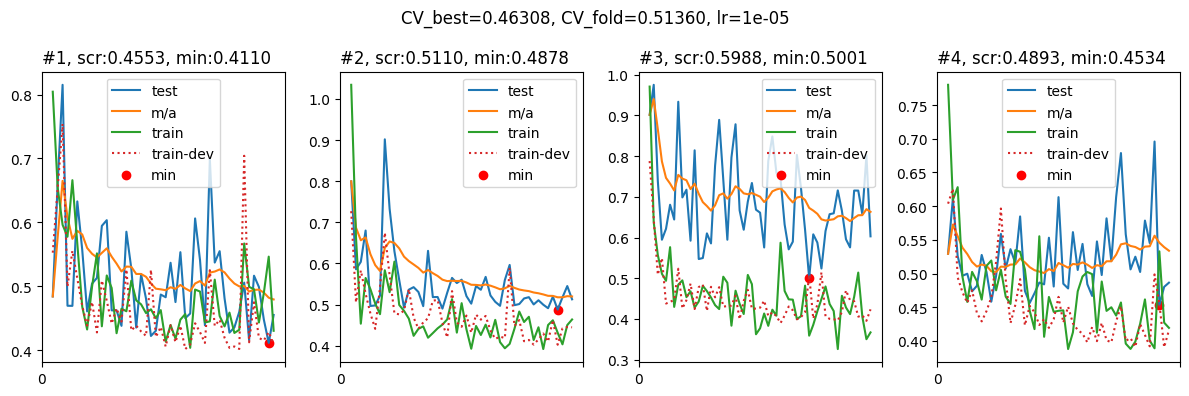

In [31]:
# def cross_validation():
with open(prompts_train_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
#     prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)
    
plt.figure(figsize=(12,4))

folds_list = list(prompts.prompt_id)
score_type = 'content'
batch_size = 5
lr = 1e-05
lr_head = 1e-04
weight_decay = 1e-02
n_epochs = 1

scores_best = []
scores_fold = []

fig, axs = plt.subplots(1, len(folds_list), figsize=(12,4), layout='tight')

for i, fold in enumerate(folds_list, 1):
    train_loader, test_loader, train_dev_loader = loaders_init(score_type, batch_size, fold)

    fold_score, best_score, n_iter, test_losses, train_losses, train_dev_losses = train_model(n_epochs,
                                                                                              lr, weight_decay,
                                                                                              i, lr_head)
    scores_fold.append((fold_score))
    scores_best.append(best_score)

    axs[i-1] = axis_set(axs[i-1])

mean_best_score = np.mean(scores_best)
mean_fold_score = np.mean(scores_fold)

fig.suptitle(f'CV_best={mean_best_score:.5f}, CV_fold={mean_fold_score:.5f}, lr={lr}')
fig.savefig('res_figure.png', dpi=200)

In [32]:
# fig.set_figwidth()

In [33]:
# fig.savefig('res_figure.png', dpi=200)

In [34]:
# fig